In [161]:
import numpy as np
import pandas as pd
from scipy.spatial.distance import cosine
from numpy import linalg as la
import matplotlib.pyplot as plt
from scipy import stats

classmap = pd.read_csv("class_map_seedlings.csv")

from object_vectors import *

## Build random vectors

generate 27 random vectors and assign them to one of the 27 object classes

### for images

27 x 2048

In [162]:
imgvecs = np.random.randn(27, 2048)
imgvecs = list(zip(classmap.obj_class.values, imgvecs))

### for words

27 x 300

In [163]:
wrdvecs = np.random.randn(27, 300)
wrdvecs = list(zip(classmap.obj_class.values, wrdvecs))

## compute pairwise distances

In [164]:
imgvecs.sort(key=lambda x: x[0])
pairwise_img_matrix = []
for vec in imgvecs:
    for other in imgvecs:
        pairwise_img_matrix.append((vec[0], other[0], cosine(vec[1], other[1])))

imgdist = pd.DataFrame(pairwise_img_matrix, columns=["word", "other", "cos_dist"]).query("word != other")

In [165]:
wrdvecs.sort(key=lambda x: x[0])
pairwise_wrd_matrix = []
for vec in wrdvecs:
    result = []
    for other in wrdvecs:
        pairwise_wrd_matrix.append((vec[0], other[0], cosine(vec[1], other[1])))
wrddist = pd.DataFrame(pairwise_wrd_matrix, columns=["word", "other", "cos_dist"]).query("word != other")

In [166]:
def join(wrd, img):
    wrd = wrd.rename({"cos_dist": "cos_word"}, axis="columns")
    img = img.rename({"cos_dist": "cos_image"}, axis="columns")
    wrd['id'] = ["{}_{}".format(x.word, x.other) for i, x in wrd.iterrows()]
    img['id'] = ["{}_{}".format(x.word, x.other) for i, x in img.iterrows()]
    joined = pd.merge(wrd, img, on='id')
    joined = joined.loc[:, lambda df: ['id', 'cos_image', 'cos_word']]
    joined['word'] = joined.id.str.split("_").str[0]
    joined['other'] = joined.id.str.split("_").str[1]
    joined = joined.drop(columns=['id'])
    joined = joined[['word', 'other', 'cos_image', 'cos_word']]
    return joined

In [167]:
def filter_unique(dists):
    df = dists.copy()
    exists = []
    for i, x in df.iterrows():
        if "{}_{}".format(x.other, x.word) in exists:
            df.drop(i, inplace=True)
        else:
            exists.append("{}_{}".format(x.word, x.other))
    return df

In [168]:
df = join(wrddist, imgdist)
df_uniq = filter_unique(df)
df.to_csv("pairwise_distances_RANDOM.csv", index=False)

## Compare structure across image vs. word spaces

there's no conserved relationships....as you'd expect

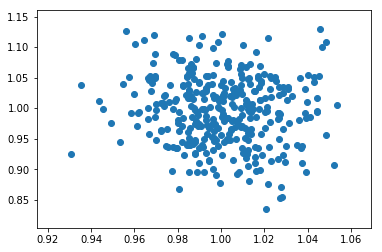

(-0.08935417381133523, 0.0946381103917435)

In [169]:
plt.scatter(df_uniq.cos_image, df_uniq.cos_word)
plt.show()
stats.pearsonr(df_uniq.cos_image, df_uniq.cos_word)

# How much overlap is there between closest neighbors in image and word space?

In [170]:
df2 = pd.DataFrame()

for idx, group in df.groupby("word"):
    grp = group.copy()
    grp["zscore_img"] = stats.zscore(group.cos_image)
    grp["zscore_word"] = stats.zscore(group.cos_word)
    df2 = df2.append(grp)

In [171]:
overlaps = df2.query("(zscore_word <= -1) & (zscore_img <= -1)")
overlaps.to_csv("overlapping_pairwise.csv", index=False)

In [172]:
words = {}

for idx, item in df2.iterrows():
    avg_zscore = round(float((item.zscore_img+item.zscore_word))/2, 2)
    if item.word not in words:
        if item.zscore_img <= -1:
            words[item.word] = [[(item.other, avg_zscore)],[]]
        if item.zscore_word <= -1:
            words[item.word] = [[],[(item.other, avg_zscore)]]
    else:
        if item.zscore_img <= -1:
            words[item.word][0].append((item.other, avg_zscore))
        if item.zscore_word <= -1:
            words[item.word][1].append((item.other, avg_zscore))

In [182]:
overlap_ratios = {}
neighbor_counts = []
for key, values in words.items():
    intersect = set(values[0]) & set(values[1])
    n = len(intersect)
    neighbor_counts.append((key, n, len(values[0]), len(values[1])))
    
    overlap_ratios[key] = [round(float(n)/len(set(values[0]+values[1])), 3), 
                           [list(x) + [True] for x in intersect] +
                           [list(x) + [False] for x in values[0]+values[1] if x not in intersect]]

neighbor_counts = pd.DataFrame(neighbor_counts, 
                                columns = ["word", "overlap_count", 
                                           "image_count", "word_count"])
neighbor_counts.to_csv("neighbor_counts_RANDOM.csv", index=False)

In [174]:
overlap_ratios_list = [(x, y[0], sorted(list(y[1]), key=lambda x: x[1])) for x, y in overlap_ratios.items()]

In [175]:
overlap_table = pd.DataFrame(overlap_ratios_list, columns = ["word", "overlap_ratio", "neighbors"])

In [176]:
np.mean(overlap_table.overlap_ratio)

0.048037037037037045

In [177]:
overlap_table.to_csv("overlap_table_RANDOM.csv", index=False)

In [178]:
neighbor_counts

,word,overlap_count,image_count,word_count
0,apple,1,4,6
1,baby,0,4,4
2,ball,1,6,5
3,bear,0,5,3
4,block,0,4,5
5,book,0,4,4
6,bottle,0,3,6
7,car,0,2,5
8,cat,2,4,6
9,chair,1,4,4
